# MIR replicates latent space

> Using Woodwell ring trial and CVAE to create mid-infrared spectra embeddings

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [ ]:
from pathlib import Path
from functools import partial
# import itertools

import fastcore.all as fc

import pandas as pd
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


from torcheval.metrics import MeanSquaredError
from torch.optim import lr_scheduler
from torch import optim, nn

import torch
import torch.nn.functional as F
from torch.nn import init

from lssm.loading import load_mirs_ring_trial, get_spectra_pair_idxs
from lssm.dataloaders import CrossSpectraDataset, get_dls
from lssm.callbacks import (MetricsCB, BatchSchedCB, BatchTransformCB,
                            DeviceCB, TrainCB, ProgressCB)
from lssm.learner import Learner
from lssm.callbacks import Callback
from lssm.visualization import plot_spectra


## Data loading

In [ ]:
fname = Path().home()/'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001/RT_STD_allMIRspectra_raw.csv'
df = load_mirs_ring_trial(fname)
X_names = [int(c) for c in df.columns[2:][::-1]]

In [ ]:
df = df.iloc[:100,:]

In [ ]:
pair_idxs_train, pair_idxs_valid  = train_test_split(get_spectra_pair_idxs(df), 
                                                     test_size=0.2, random_state=41)

In [ ]:
train_ds, valid_ds = [CrossSpectraDataset(df, pair_idxs) 
                      for pair_idxs in [pair_idxs_train, pair_idxs_valid]]

In [ ]:
# Then PyTorch dataloaders
dls = get_dls(train_ds, valid_ds, bs=32)

first_batch = next(iter(dls.train))
print(f'First batch X dim: {first_batch[0].shape}')
print(f'First batch y dim: {first_batch[1].shape}')

First batch X dim: torch.Size([32, 1, 1676])
First batch y dim: torch.Size([32, 1, 1676])


In [ ]:
class SNVTfm(): 
    """
    Apply SNV to input or to both input and output when used with a Variational Auto-Encoder
    """
    def __init__(self, is_VAE=True):
        self.is_VAE = is_VAE

    def __call__(self, b): 
        x, y = b
        spectra = [x, y] if self.is_VAE else [x]
        spectra_tfm = []
        for s in spectra:
            mean, std = torch.mean(s, axis=2).unsqueeze(1), torch.std(s, axis=2).unsqueeze(1)
            spectra_tfm.append((s - mean)/std)
        return spectra_tfm

## Model

<!-- $$1 + \frac{n + 2p - k_s}{s}$$ -->

<!-- $$1 + ((n + 2p -k_s)) // stride -->

### Resnet VAE

In [ ]:
# def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm1d, n_embeddings=2):
#     # self.avgpool = nn.AdaptiveAvgPool1d(1)
#     layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
#     layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
#     # layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
#     # layers += [nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(nfs[-1], n_embeddings, bias=False)]
#     # return nn.Sequential(*layers).to(def_device)
#     return nn.Sequential(*layers)

In [ ]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [ ]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)
    
iw = partial(init_weights, leaky=0.1)

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv1d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [ ]:
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool1d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): 
        return self.act(self.convs(x) + self.idconv(self.pool(x)))

class ResBlockUp(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        self.resblock = ResBlock(ni, nf, act=act, norm=norm, stride=stride)

    def forward(self, x): 
        return self.resblock(self.upsample(x))

class Encoder(nn.Module):
    def __init__(self, act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm1d, z_dim=2):
        super(Encoder, self).__init__()
        self.layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
        self.layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
        self.layers += [nn.AdaptiveAvgPool1d(1), nn.Flatten()]
        self.resblocks = nn.Sequential(*self.layers)
        self.fc_mu = nn.Linear(nfs[-1], z_dim)
        self.fc_logvar = nn.Linear(nfs[-1], z_dim)

    def forward(self, x):
        x = self.resblocks(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)        
        return mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, in_shape, act=nn.ReLU, 
                 nfs=(256, 128, 64, 32, 16, 8), 
                 norm=nn.BatchNorm1d, z_dim=2):
        super(Decoder, self).__init__()
        self.feat_len = 1 + in_shape//2**(len(nfs)-1)
        self.lin = nn.Linear(z_dim, nfs[0]*self.feat_len, bias=False)
        self.nfs = nfs
        
        layers = []
        layers += [ResBlockUp(nfs[i], nfs[i+1], act=act, norm=norm, stride=1) for i in range(len(nfs)-1)]    
        layers.append(ResBlock(nfs[-1], 1, act=act_gr, norm=nn.BatchNorm1d, stride=1))
        self.resblocks = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.lin(x)
        x = x.reshape(-1, self.nfs[0], self.feat_len)
        return self.resblocks(x)
    
class CVAE(nn.Module):
    def __init__(self, in_shape=1676, z_dim=2, nfs=(8,16,32,64,128,256)):
        super(CVAE, self).__init__()
        self.in_shape = in_shape
        self.encoder = Encoder(nfs=nfs, z_dim=z_dim)
        self.decoder = Decoder(in_shape, nfs=nfs[::-1], z_dim=z_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_rec = self.decoder(z)
        strip_idx = x_rec.shape[-1] - self.in_shape
        return x_rec[:,:,:-strip_idx], mu, logvar

In [ ]:
first_batch[0].shape

torch.Size([32, 1, 1676])

In [ ]:
vae = CVAE(nfs=(8,16,32,64))

In [ ]:
x_rec, _, _ = vae(first_batch[0])
x_rec.shape

torch.Size([32, 1, 1676])

### Training

In [ ]:
class VAETrainCB(Callback):    
    def predict(self, learn): 
        learn.preds = learn.model(learn.batch[0])
        
    def get_loss(self, learn): 
        y_hat, mu, logvar = learn.preds
        y = learn.batch[1]
        learn.loss = learn.loss_func(y_hat, y, mu, logvar)
        
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()
    

from copy import copy
from torcheval.metrics import Mean
from lssm.callbacks import to_cpu

class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        y_hat, y = [s.squeeze(1) for s in [learn.preds[0], y]]
        for m in self.metrics.values(): 
            # m.update(to_cpu(learn.preds[0]), y)
            m.update(to_cpu(y_hat), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [ ]:
# Loss Function
def loss_function(recon_x, x, mu, logvar):
    criterion = nn.MSELoss()
    MSE = criterion(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [ ]:
### lr_find
assess_lr = True
model = CVAE(nfs=(8,16,32,64), z_dim=2).apply(iw)
epochs = 2
lr = 1e-4

metrics = MetricsCB(mse=MeanSquaredError())
tmax = epochs * len(dls.train)
# sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

_snv = BatchTransformCB(SNVTfm())
# xtra = [BatchSchedCB(sched)] if assess_lr else []
cbs = [DeviceCB(device='cpu'), _snv, VAETrainCB(), metrics, ProgressCB(plot=False)]
learn = Learner(model, dls, loss_function, lr=lr, cbs=cbs, opt_func=optim.AdamW)

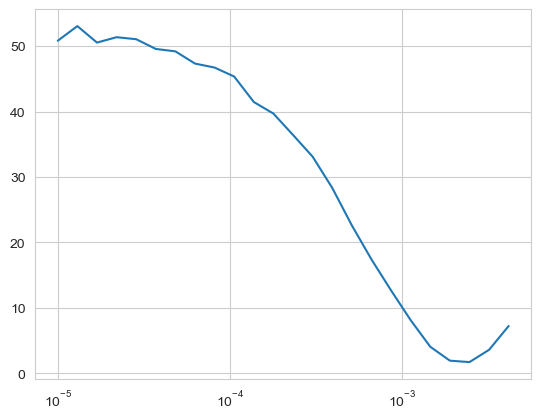

In [ ]:
learn.lr_find()

In [ ]:
model = CVAE(nfs=(8,16,32,64), z_dim=2)
epochs = 2
lr = 1e-4

metrics = MetricsCB(mse=MeanSquaredError())

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

_snv = BatchTransformCB(SNVTfm())
xtra = [BatchSchedCB(sched)]
cbs = [DeviceCB(device='cpu'), _snv, VAETrainCB(), metrics, ProgressCB(plot=False)]

learn = Learner(model, dls, loss_function, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
# learn = Learner(model, dls, loss_function, lr=lr, cbs=cbs, opt_func=optim.AdamW)

learn.fit(epochs)

mse,loss,epoch,train
0.872,1.327,0,train
0.383,0.390,0,eval
0.334,0.337,1,train
0.318,0.322,1,eval


In [ ]:
X_recon = learn.model(learn.batch[0])[0]

In [ ]:
X_recon.shape

torch.Size([64, 1, 1676])

<Figure size 640x480 with 0 Axes>

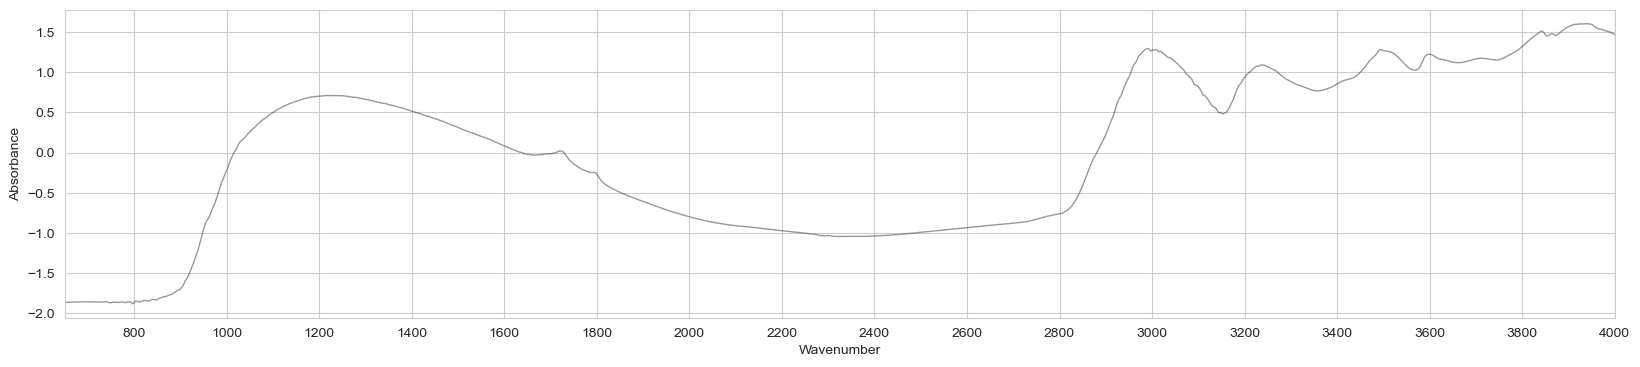

In [ ]:
idx = 4
plot_spectra(learn.batch[0][idx].squeeze(1).cpu(), X_names, alpha=0.5, sample=1)

<Figure size 640x480 with 0 Axes>

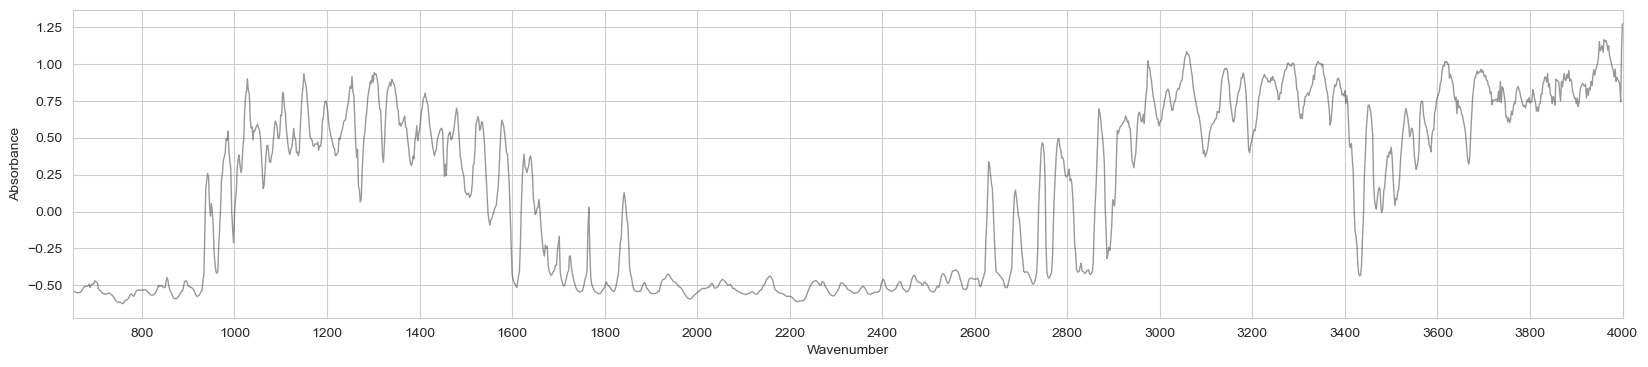

In [ ]:
plot_spectra(X_recon[idx].cpu().detach().numpy(), X_names, alpha=0.5, sample=1)

In [ ]:
# def conv_output_size(n, p, ks, s):
#     return 1 + ((n + 2*p - ks) // s)

# n = 1676
# p = 1
# ks = 3
# s = 2
# conv_output_size(n, p, ks, s)
# n = 838
# conv_output_size(n, p, ks, s)

### VAE

Resources:
- https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [ ]:
# Define the Encoder
# class Encoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, z_dim):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc_mu = nn.Linear(hidden_dim, z_dim)
#         self.fc_logvar = nn.Linear(hidden_dim, z_dim)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         mu = self.fc_mu(x)
#         logvar = self.fc_logvar(x)
#         return mu, logvar

# # Define the Decoder
# class Decoder(nn.Module):
#     def __init__(self, z_dim, hidden_dim, output_dim):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(z_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         return x

# # Define the Variational Autoencoder (VAE)
# class FCVAE(nn.Module):
#     def __init__(self, input_dim, hidden_dim, z_dim):
#         super(FCVAE, self).__init__()
#         self.encoder = Encoder(input_dim, hidden_dim, z_dim)
#         self.decoder = Decoder(z_dim, hidden_dim, input_dim)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5*logvar)
#         eps = torch.randn_like(std)
#         return mu + eps*std

#     def forward(self, x, num_samples=1):
#         mu, logvar = self.encoder(x)
#         z = self.reparameterize(mu, logvar)
        
#         # Generating multiple samples
#         outputs = []
#         for _ in range(num_samples):
#             z_sample = self.reparameterize(mu, logvar)
#             outputs.append(self.decoder(z_sample))
        
#         if num_samples == 1:
#             return torch.stack(outputs).mean(axis=0), mu, logvar
#         else:
#             return torch.stack(outputs), mu, logvar

# # Define the VAE Loss function
# def vae_loss(reconstructed_x, x, mu, logvar):
#     # Reconstruction loss (MSE)
#     recon_loss = nn.MSELoss()(reconstructed_x, x)
#     # KL divergence loss
#     kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return recon_loss + kl_loss

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, z_dim):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc_mu = nn.Linear(hidden_dim, z_dim)
#         self.fc_logvar = nn.Linear(hidden_dim, z_dim)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         mu = self.fc_mu(x)
#         logvar = self.fc_logvar(x)
#         return mu, logvar

# # Define the Decoder
# class Decoder(nn.Module):
#     def __init__(self, z_dim, hidden_dim, output_dim):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(z_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         return x

# # Define the Variational Autoencoder (VAE)
# class FCVAE(nn.Module):
#     def __init__(self, input_dim, hidden_dim, z_dim):
#         super(FCVAE, self).__init__()
#         self.encoder = Encoder(input_dim, hidden_dim, z_dim)
#         self.decoder = Decoder(z_dim, hidden_dim, input_dim)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5*logvar)
#         eps = torch.randn_like(std)
#         return mu + eps*std

#     def forward(self, x, num_samples=1):
#         mu, logvar = self.encoder(x)
#         z = self.reparameterize(mu, logvar)
        
#         # Generating multiple samples
#         outputs = []
#         for _ in range(num_samples):
#             z_sample = self.reparameterize(mu, logvar)
#             outputs.append(self.decoder(z_sample))
        
#         if num_samples == 1:
#             return torch.stack(outputs).mean(axis=0), mu, logvar
#         else:
#             return torch.stack(outputs), mu, logvar

# # Define the VAE Loss function
# def vae_loss(reconstructed_x, x, mu, logvar):
#     # Reconstruction loss (MSE)
#     # recon_loss = nn.MSELoss()(reconstructed_x, x)
#     recon_loss = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
#     # KL divergence loss
#     kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return recon_loss + kl_loss

In [ ]:
# Example Usage
# input_dim = 1676  
# hidden_dim = 512  
# z_dim = 64  

# vae = FCVAE(input_dim, hidden_dim, z_dim)
# optimizer = optim.Adam(vae.parameters(), lr=0.001)

# # Assuming a trained VAE
# sample_spectrum = torch.rand(32, input_dim)  # For demonstration purposes
# print(sample_spectrum.shape)
# replicates, _, _ = vae(sample_spectrum, num_samples=1)  # Generating 10 replicates

# print(replicates.shape)  # Should return torch.Size([10, 1, 1600])


In [ ]:
# def lin(ni, nf, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
#     layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
#     if act : layers.append(act())
#     if norm: layers.append(norm(nf))
#     return layers

In [ ]:
# torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0,

In [ ]:
# def conv(in_channels, 
#          out_channels, 
#          kernel_size=3,
#          stride=2, 
#          act=nn.SiLU, 
#          norm=nn.BatchNorm1d, bias=True):
#     layers = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=1))
#     if act : layers.append(act())
#     if norm: layers.append(norm(out_channels))
#     return layers

In [ ]:
# conv(1, 16)(first_batch[0]).shape

In [ ]:
conv1 = conv(1, 16)
conv2 = conv(16, 32)
# conv3 = conv(32, 64)

conv3(conv2(conv1(first_batch[0]))).shape

torch.Size([32, 64, 210])

In [ ]:
64*210

13440

In [ ]:
# # Basic 1D CVAE
# # Convolutional Variational Autoencoder

# # Define the Encoder
class Encoder(nn.Module):
    def __init__(self, z_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = conv(1, 16)
        self.conv2 = conv(16, 32)
        # self.dropout1 = nn.Dropout(0.5)
        self.fc_mu = nn.Linear(32 * 419, z_dim)  # Assuming that the output is 419 after the conv layers
        self.fc_logvar = nn.Linear(32 * 419, z_dim)
        # iw(self)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        # x = self.dropout1(x)
        mu = self.fc_mu(x)
        print(mu.shape)
        logvar = self.fc_logvar(x)
        print(logvar.shape)
        return mu, logvar

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, z_dim=2):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(z_dim, 32 * 419)
        # self.dropout1 = nn.Dropout(0.5)
        self.deconv1 = nn.ConvTranspose1d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose1d(16, 1, 3, stride=2, padding=1, output_padding=1)
        # self.avgpool = nn.AvgPool1d(3, stride=1, padding=1)
        # iw(self)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 32, 419)  # Reshape back to a volume
        x = torch.relu(self.deconv1(x))
        # x = self.avgpool(x)
        # x = torch.sigmoid(self.deconv2(x))  # Sigmoid for binary cross-entropy loss
        x = self.deconv2(x)
        # x = self.avgpool(x)
        # x = self.avgpool(x)
        return x

# Define the Variational Autoencoder (VAE)
class CVAE(nn.Module):
    def __init__(self, z_dim=2):
        super(CVAE, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        print('z dim', z.shape)
        return self.decoder(z), mu, logvar

In [ ]:
first_batch[0].shape

torch.Size([32, 1, 1676])

In [ ]:
CVAE()(first_batch[0])[0].shape

torch.Size([32, 2])
torch.Size([32, 2])
z dim torch.Size([32, 2])


torch.Size([32, 1, 1676])

In [ ]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)
        return out

In [ ]:
class ResNet1D(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet1D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        
# Example: ResNet with 3 blocks in each layer
model = ResNet1D(ResidualBlock1D, [3, 3, 3, 3])

# Example input (batch_size, channels, length)
input = torch.randn(1, 1, 256)
output = model(input)

In [ ]:
output.shape

torch.Size([1, 10])

In [ ]:
class ResNetEncoder1D(nn.Module):
    # ... (Same as ResNet1D, but include the latent space representation)
    def __init__(self, block, layers, latent_dim=20):
        super(ResNetEncoder1D, self).__init__()
        # ... (Other initializations)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_log_var = nn.Linear(512, latent_dim)

    def forward(self, x):
        # ... (Same as ResNet1D forward pass up to avgpool)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
class ResNetDecoder1D(nn.Module):
    def __init__(self, block, layers, latent_dim=20, output_channels=1):
        super(ResNetDecoder1D, self).__init__()
        self.initial_fc = nn.Linear(latent_dim, 512)

        # Invert the ResNet layers
        self.layer4 = self._make_layer(block, 256, layers[3], upsample=True)
        self.layer3 = self._make_layer(block, 128, layers[2], upsample=True)
        self.layer2 = self._make_layer(block, 64, layers[1], upsample=True)
        self.layer1 = self._make_layer(block, output_channels, layers[0], upsample=True, final_layer=True)

    def _make_layer(self, block, out_channels, blocks, upsample=False, final_layer=False):
        layers = []
        if upsample:
            # Upsample at the beginning of the layer if it's not the first layer
            layers.append(nn.Upsample(scale_factor=2, mode='linear', align_corners=True))

        # Add residual blocks
        for _ in range(blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, z):
        x = F.relu(self.initial_fc(z))
        x = x.view(-1, 512, 1)  # Reshape to match the expected input size for the transposed convolutions
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        return x

In [ ]:
class VAE(nn.Module):
    def __init__(self, block, layers, latent_dim=20, output_channels=1):
        super(VAE, self).__init__()
        self.encoder = ResNetEncoder1D(block, layers, latent_dim=latent_dim)
        self.decoder = ResNetDecoder1D(block, layers, latent_dim=latent_dim, output_channels=output_channels)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

# Example usage
vae_model = VAE(ResidualBlock1D, [3, 3, 3, 3], latent_dim=20, output_channels=1)
input = torch.randn(1, 1, 256)
reconstructed, mu, log_var = vae_model(input)

In [ ]:
# x_decoded, mu, logvar = CVAE()(first_batch[0])

In [ ]:
first_batch = next(iter(dls.train))

In [ ]:
X_recon = learn.model(learn.batch[0])[0]
idx = 4
plot_spectra(learn.batch[0][idx].squeeze(1).cpu(), X_names, alpha=0.5, sample=1)
plot_spectra(X_recon[idx].cpu().detach().numpy(), X_names, alpha=0.5, sample=1)